In [2]:
import argparse
from datetime import datetime
import json
from pprint import pprint

from explorecourses import *  # pip install the explorecourses package
import pandas as pd

In [3]:
import requests
from typing import List, Tuple
import xml.etree.ElementTree as ET

In [4]:
_URL = "https://explorecourses.stanford.edu/"
_session = requests.Session()

In [5]:
def get_academic_year_str(years_ago: int = 0) -> str:
    """
    Get the academic year in string form for some number of academic years ago.

    Args:
        years_ago (int): Number of academic years prior to now.

    Returns:
        Academic year formatted like '{start_year}-{end_year}'.
    """
    academic_year_start = datetime.now().year - years_ago
    
    # If before September, academic year started last year
    if datetime.now().month < 9:
        academic_year_start -= 1

    return f"{academic_year_start}-{academic_year_start+1}"


def get_course_dict(course: Course, include_sections: bool = True):
    """
    Converts course to string dict representation.

    Args:
        course (Course): Course to convert.

    Returns:
        course_dict: Course represented as dict of strings.
    """
    if include_sections:
        for section in course.sections:
            for schedule in section.schedules:
                schedule.instructors = tuple(str(ins) 
                                             for ins in schedule.instructors)
            section.schedules = tuple(schedule.__dict__ 
                                      for schedule in section.schedules)
            section.attributes = tuple(str(attr)
                                       for attr in section.attributes)
        course.sections = json.dumps(tuple(section.__dict__ 
                                           for section in course.sections))
    else:
        course.sections = None

    course.attributes = tuple(str(attr) for attr in course.attributes)
    course.objectives = tuple(str(obj) for obj in course.objectives)
    course.tags = tuple(str(tag) for tag in course.tags)

    course_dict = course.__dict__
    return course_dict 


def download_one_year_course_data(years_ago: int = 0, 
                                  verbose: bool = False,
                                  include_sections: bool = True) -> pd.DataFrame:
    """
    Downloads a single year of course data and converts to pandas DataFrame.

    Args:
        years_ago (int): Number of academic years ago (including current) to 
                         download.
    verbose (bool): Whether to use verbose output.
        
    Returns:
        one_year_course_df (pd.DataFrame): One year of course data.
    """
    academic_year_str = get_academic_year_str(years_ago)
    if verbose: 
        print(f"Downloading data for academic year: {academic_year_str}")
        
    def get_courses_by_query(query: str, *filters: str, 
                             year=None) -> List[Course]:

        """
        Gets all courses matched by a search query.
        Args:
            query (str): The search query.
            *filters (str): Search query filters.
            year (Optional[str]): The academic year within which to retrieve 
                courses (e.g., "2017-2018"). Defaults to None.
        Returns:
            List[Course]: The courses matching the search query.
        """
        
        url = _URL + "search"

        payload = {
            "view": "xml-20200810",
            "filter-coursestatus-Active": "on",
            "q": query,
        }
        payload.update({f: "on" for f in filters})
        if year:
            payload.update({"academicYear": year.replace('-', '')})

        res = _session.get(url, params=payload)

        root = ET.fromstring(res.content)
        courses = root.findall(".//course")

        return [Course(course) for course in courses]
    
    courses = get_courses_by_query(query='all courses', 
                                   year=academic_year_str)
    if verbose:
        print(f"Converting data for academic year: {academic_year_str}")
    return pd.DataFrame(data=(get_course_dict(course, include_sections) 
                              for course in courses))



def download_multiple_years_course_data(num_years: int = 11, 
                                        verbose: bool = False,
                                        include_sections: bool = True
                                       ) -> pd.DataFrame:
    """
    Downloads multiple years of course data and converts to pandas DataFrame.

    Args:
        num_years (int): The number of years (including current) to download.
        verbose (bool): Whether to use verbose output.
    """
    return pd.concat(
            objs=(download_one_year_course_data(years_ago, 
                                                verbose, 
                                                include_sections)
                  for years_ago in range(num_years)), 
            axis=0)

In [7]:
num_years = 11
verbose = True
include_sections = True

all_years_course_data_df = download_multiple_years_course_data(
        num_years, verbose, include_sections)

Converting data for academic year: 2020-2021
Converting data for academic year: 2019-2020
Converting data for academic year: 2018-2019
Converting data for academic year: 2017-2018
Converting data for academic year: 2016-2017
Converting data for academic year: 2015-2016
Converting data for academic year: 2014-2015
Converting data for academic year: 2013-2014
Converting data for academic year: 2012-2013
Converting data for academic year: 2011-2012
Converting data for academic year: 2010-2011


In [8]:
all_years_course_data_df.to_csv('all_course_data_01_13_2021.csv') 

### Start here if you have already saved it

In [23]:
all_years_course_data_df = pd.read_csv('all_course_data_01_13_2021.csv')

In [24]:
all_years_course_data_df[['year', 'code']].drop_duplicates().groupby('year').count()

,code
year,
2010-2011,3162
2011-2012,3282
2012-2013,3279
2013-2014,3525
2014-2015,3914
2015-2016,4083
2016-2017,4334
2017-2018,4459
2018-2019,4576


In [25]:
#all_2010s_df = all_years_course_data_df.loc[(all_years_course_data_df['year'] != '2020-2021')]

In [26]:
academic_year_df = all_2010s_df[all_2010s_df['attributes'].apply(lambda x: 'NQTR::AUT' in x or 'NQTR::WIN' in x or 'NQTR::SPR' in x)]\
    [['year', 'subject', 'code', 'title', 'attributes', 'description', 'sections', 'gers']]

academic_year_df['sections_clean'] = academic_year_df['sections']\
    .apply(lambda x: [(c['component'], c['curr_class_size'], c['term'].split()[-1]) 
                     for c in json.loads(x) 
                     if c['term'].split()[-1].lower() != 'summer'])
academic_year_df = academic_year_df.explode('sections_clean')

In [27]:
academic_year_df = academic_year_df\
    .drop('sections', 'columns')\
    .loc[academic_year_df['sections_clean'].notnull()]

In [28]:
academic_year_df['component'] = academic_year_df['sections_clean'].apply(lambda x: x[0])
academic_year_df['enrollment'] = academic_year_df['sections_clean'].apply(lambda x: x[1])
academic_year_df['term'] = academic_year_df['sections_clean'].apply(lambda x: x[2])
academic_year_df = academic_year_df.drop(['sections_clean', 'attributes'], 'columns')

In [29]:
# Filter discussions, independent studies, labs, thesis/dissertation, and recitation
academic_year_df = academic_year_df[~academic_year_df['component'].isin(
    ['DIS', 'INS', 'LBS', 'T/D', 'RES'])]

In [30]:
term_enrollment_df = academic_year_df\
    .groupby(['year', 'subject', 'code', 'title', 'description', 'term'])\
    .agg({'enrollment': 'sum'})\
    .sort_values(by='year').reset_index()

In [31]:
term_enrollment_df.loc[term_enrollment_df['code'] == '224N']

,year,subject,code,title,description,term,enrollment
11793,2010-2011,CS,224N,Natural Language Processing (LINGUIST 284),Methods for processing human language informat...,Winter,89
11794,2010-2011,CS,224N,Natural Language Processing (LINGUIST 284),Methods for processing human language informat...,Autumn,11
38560,2011-2012,CS,224N,Natural Language Processing (LINGUIST 284),Methods for processing human language informat...,Winter,34
38561,2011-2012,CS,224N,Natural Language Processing (LINGUIST 284),Methods for processing human language informat...,Spring,4
38562,2011-2012,CS,224N,Natural Language Processing (LINGUIST 284),Methods for processing human language informat...,Autumn,116
59017,2012-2013,CS,224N,Natural Language Processing (LINGUIST 284),Methods for processing human language informat...,Autumn,111
59026,2012-2013,CS,224N,Natural Language Processing (LINGUIST 284),Methods for processing human language informat...,Spring,48
80108,2013-2014,CS,224N,Natural Language Processing (LINGUIST 284),Methods for processing human language informat...,Spring,3
80110,2013-2014,CS,224N,Natural Language Processing (LINGUIST 284),Methods for processing human language informat...,Autumn,161
101818,2014-2015,CS,224N,Natural Language Processing (LINGUIST 284),Methods for processing human language informat...,Spring,15


In [32]:
year_enrollment_df = term_enrollment_df\
    .groupby(['year', 'subject', 'code', 'title', 'description'])\
    .agg({'enrollment': 'sum'})\
    .sort_values(by='year').reset_index()

In [33]:
year_enrollment_df.loc[year_enrollment_df['code'] == '221']

,year,subject,code,title,description,enrollment
15,2010-2011,MCP,221,"Advanced Cell Biology (BIO 214, BIOC 224)",For Ph.D. students. Current research on cell s...,70
495,2010-2011,MUSIC,221,Topics in the History of Theory,The intersection of music theory and compositi...,261
610,2010-2011,NBIO,221,Frontiers in Translational Medicine,Small group course for first year MSTP and Mas...,115
851,2010-2011,MS&E,221,Stochastic Modeling,Focus is on time-dependent random phenomena. T...,94
1056,2010-2011,IPS,221,International Organizations and Institutions,How do international organizations and institu...,16
...,...,...,...,...,...,...
78281,2019-2020,DLCL,221,Materia,Materia is a focal group on post-anthropocentr...,659
78335,2019-2020,ECON,221,Political Economy II (POLISCI 460B),Continuation of 220. Preparation for advanced ...,28
78450,2019-2020,CSB,221,Methods and Logic in Chemical and Systems Biology,"This course covers logic, experimental design ...",49
78854,2019-2020,EMED,221,"""I'm Not a Doctor but I Play One on TV"": Explo...",Have you ever watched an episode of a medical ...,18


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [43]:
year_enrollment_df['title'] = year_enrollment_df['title'].str.lower()
year_enrollment_df['description'] = year_enrollment_df['description'].str.lower()

### Enrollment in AI classes

In [178]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

[]

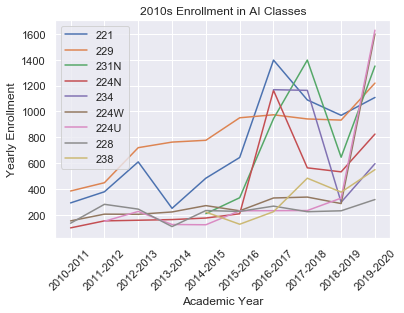

In [44]:
codes = ['221', '229', '231N', '224N', '234', '224W', '224U', '228', '238']

for code in codes:
    code_df = year_enrollment_df.loc[(year_enrollment_df['code'] == code) & (year_enrollment_df['subject'] == 'CS')]
    plt.plot(code_df['year'], code_df['enrollment'], label=code)

plt.ylabel('Yearly Enrollment')
plt.xlabel('Academic Year')
plt.title('2010s Enrollment in AI Classes')
plt.legend()
plt.xticks(rotation=45)
plt.plot()

In [45]:
#year_enrollment_df.to_csv('cs_yearly_enrollment_2010s.csv')

#term_enrollment_df.to_csv('cs_term_enrollment_2010s.csv')

### Enrollment in tech / tech-related classes

In [47]:
import numpy as np

In [104]:
tech_keys = ['data science', 'technology', 'cyber', 'ai', 'artifical intelligence', 'computer science', 'computer', 'digital']
ethics_keys = ['society', 'ethics', 'moral', 'social impact', 'justice']

In [105]:
year_enrollment_df['tech_description'] = 0
year_enrollment_df['tech_title'] = 0
year_enrollment_df['ethics_description'] = 0
year_enrollment_df['ethics_title'] = 0

for i, row in year_enrollment_df.iterrows():
    year_enrollment_df.at[i, 'tech_title'] = sum([key in row['title'] for key in tech_keys])
    year_enrollment_df.at[i, 'tech_description'] = sum([key in row['description'] for key in tech_keys])
    year_enrollment_df.at[i, 'ethics_title'] = sum([key in row['title'] for key in ethics_keys])
    year_enrollment_df.at[i, 'ethics_description'] = sum([key in row['title'] for key in ethics_keys])

[]

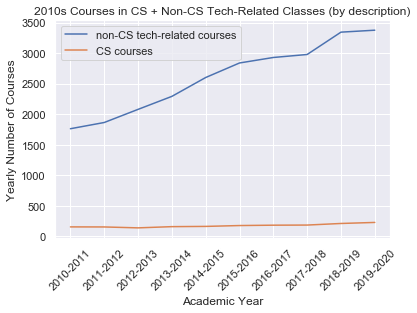

In [95]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) & (year_enrollment_df['subject'] != 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_cs = year_enrollment_df.loc[(year_enrollment_df['subject'] == 'CS')]
df_cs = df_cs.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

plt.plot(df_tech.index, df_tech['count'], label='non-CS tech-related courses')

plt.plot(df_cs.index, df_cs['count'], label='CS courses')

plt.ylabel('Yearly Number of Courses')
plt.xlabel('Academic Year')
plt.title('2010s Courses in CS + Non-CS Tech-Related Classes (by description)')
plt.legend()
plt.xticks(rotation=45)
plt.plot()

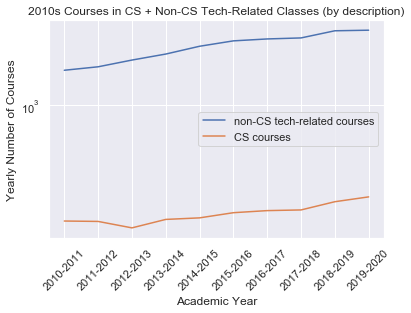

In [168]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) & (year_enrollment_df['subject'] != 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_cs = year_enrollment_df.loc[(year_enrollment_df['subject'] == 'CS')]
df_cs = df_cs.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})


fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(df_tech.index, df_tech['count'], label='non-CS tech-related courses')

ax.plot(df_cs.index, df_cs['count'], label='CS courses')

ax.set_ylabel('Yearly Number of Courses')
ax.set_xlabel('Academic Year')
ax.set_title('2010s Courses in CS + Non-CS Tech-Related Classes (by description)')
ax.legend()
ax.set_xticklabels(df_tech.index, rotation=45)
ax.set_yscale('log')
fig.savefig('cs_non-cs-tech_count.png', format='png')

In [170]:
df_cs

,enrollment,count
year,,
2010-2011,27863,152
2011-2012,36927,151
2012-2013,39052,136
2013-2014,26005,156
2014-2015,32637,160
2015-2016,42025,174
2016-2017,68969,180
2017-2018,69405,182
2018-2019,54220,208


In [171]:
df_tech

,enrollment,count
year,,
2010-2011,220088,1760
2011-2012,233961,1862
2012-2013,255371,2077
2013-2014,286237,2290
2014-2015,295121,2599
2015-2016,299190,2837
2016-2017,321951,2927
2017-2018,320965,2976
2018-2019,367435,3342


[]

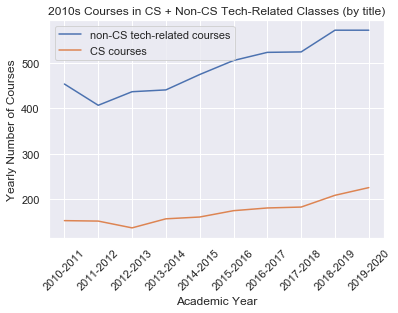

In [96]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_title'] > 0) & (year_enrollment_df['subject'] != 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_cs = year_enrollment_df.loc[(year_enrollment_df['subject'] == 'CS')]
df_cs = df_cs.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

plt.plot(df_tech.index, df_tech['count'], label='non-CS tech-related courses')

plt.plot(df_cs.index, df_cs['count'], label='CS courses')

plt.ylabel('Yearly Number of Courses')
plt.xlabel('Academic Year')
plt.title('2010s Courses in CS + Non-CS Tech-Related Classes (by title)')
plt.legend()
plt.xticks(rotation=45)
plt.plot()

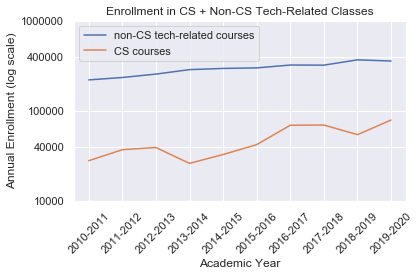

In [205]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) & (year_enrollment_df['subject'] != 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_cs = year_enrollment_df.loc[(year_enrollment_df['subject'] == 'CS')]
df_cs = df_cs.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(df_tech.index, df_tech['enrollment'], label='non-CS tech-related courses')

ax.plot(df_cs.index, df_cs['enrollment'], label='CS courses')

ax.set_ylabel('Annual Enrollment (log scale)')
ax.set_xlabel('Academic Year')
ax.set_title('Enrollment in CS + Non-CS Tech-Related Classes')
ax.legend()
ax.set_xticklabels(df_tech.index, rotation=45)
ax.set_yscale('log')
ax.set_ylim(10**4, 10**6)
ax.set_yticks([10**4, 4*10**4, 10**5, 4*10**5, 10**6])
ax.set_yticklabels([10**4, 4*10**4, 10**5,  4*10**5, 10**6])
fig.savefig('cs_non-cs-tech_enrollment.png', format='png')

In [201]:
df_tech

,enrollment,count
year,,
2010-2011,220088,1760
2011-2012,233961,1862
2012-2013,255371,2077
2013-2014,286237,2290
2014-2015,295121,2599
2015-2016,299190,2837
2016-2017,321951,2927
2017-2018,320965,2976
2018-2019,367435,3342


In [202]:
df_cs

,enrollment,count
year,,
2010-2011,27863,152
2011-2012,36927,151
2012-2013,39052,136
2013-2014,26005,156
2014-2015,32637,160
2015-2016,42025,174
2016-2017,68969,180
2017-2018,69405,182
2018-2019,54220,208


[]

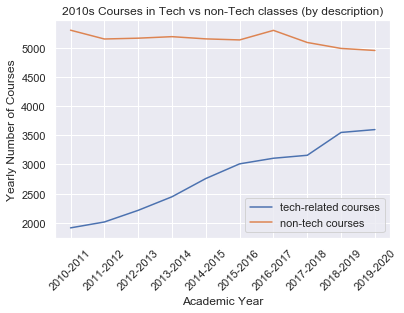

In [99]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) | (year_enrollment_df['subject'] == 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_not_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] == 0) & (year_enrollment_df['subject'] != 'CS')]
df_not_tech = df_not_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

plt.plot(df_tech.index, df_tech['count'], label='tech-related courses')

plt.plot(df_not_tech.index, df_not_tech['count'], label='non-tech courses')

plt.ylabel('Yearly Number of Courses')
plt.xlabel('Academic Year')
plt.title('2010s Courses in Tech vs non-Tech classes (by description)')
plt.legend()
plt.xticks(rotation=45)
plt.plot()

<Figure size 432x288 with 0 Axes>

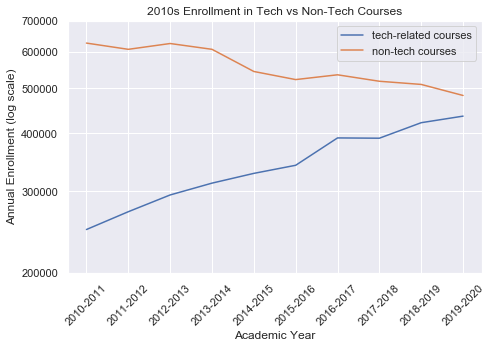

In [203]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) | (year_enrollment_df['subject'] == 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_not_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] == 0) & (year_enrollment_df['subject'] != 'CS')]
df_not_tech = df_not_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

plt.tight_layout()
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(df_tech.index, df_tech['enrollment'], label='tech-related courses')

ax.plot(df_not_tech.index, df_not_tech['enrollment'], label='non-tech courses')

ax.set_ylabel('Annual Enrollment (log scale)')
ax.set_xlabel('Academic Year')
ax.set_title('2010s Enrollment in Tech vs Non-Tech Courses')
ax.legend()
ax.set_xticklabels(df_tech.index, rotation=45)
ax.set_yscale('log')
ax.set_ylim(2*10**5, 7*10**5)
ax.set_yticks([2*10**5, 3*10**5, 4*10**5, 5*10**5, 6*10**5, 7*10**5])
ax.set_yticklabels([2*10**5, 3*10**5, 4*10**5, 5*10**5, 6*10**5, 7*10**5])
fig.savefig('tech_non-tech_enrollment.png', format='png')

### Enrollment in tech + ethics classes

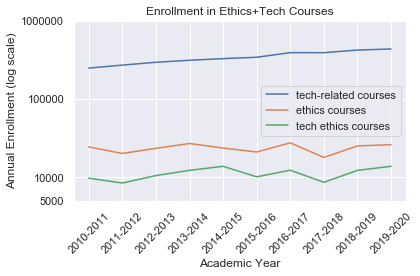

In [204]:
df_tech = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) | (year_enrollment_df['subject'] == 'CS')]
df_tech = df_tech.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_ethics = year_enrollment_df.loc[(year_enrollment_df['ethics_description'] > 0)]
df_ethics = df_ethics.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

df_tech_ethics = year_enrollment_df.loc[(year_enrollment_df['tech_description'] > 0) & (year_enrollment_df['ethics_description'] > 0)]
df_tech_ethics = df_tech_ethics.groupby('year').agg({'enrollment':'sum', 'code':'count'}).rename(columns = {'code':'count'})

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(df_tech.index, df_tech['enrollment'], label='tech-related courses')
ax.plot(df_ethics.index, df_ethics['enrollment'], label='ethics courses')
ax.plot(df_tech_ethics.index, df_tech_ethics['enrollment'], label='tech ethics courses')

ax.set_ylabel('Annual Enrollment (log scale)')
ax.set_xlabel('Academic Year')
ax.set_title('Enrollment in Ethics+Tech Courses')
ax.legend(loc='center right')
ax.set_xticklabels(df_tech.index, rotation=45)
ax.set_yscale('log')
ax.set_ylim(5*10**3, 10**6)
ax.set_yticks([5*10**3,  10**4, 10**5, 10**6])
ax.set_yticklabels([5*10**3,  10**4, 10**5, 10**6])

fig.savefig('tech_ethics_enrollment.png', format='png')

### Enrollment in CS 181 + 182

[]

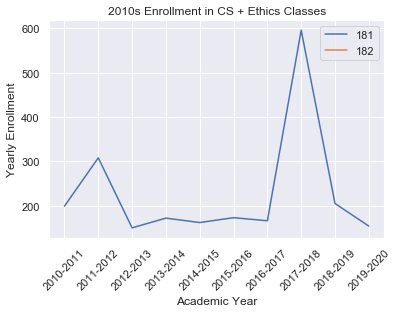

In [38]:
codes = ['181', '182']

for code in codes:
    code_df = year_enrollment_df.loc[(year_enrollment_df['code'] == code) & (year_enrollment_df['subject'] == 'CS')]
    plt.plot(code_df['year'], code_df['enrollment'], label=code)

plt.ylabel('Yearly Enrollment')
plt.xlabel('Academic Year')
plt.title('2010s Enrollment in CS + Ethics Classes')
plt.legend()
plt.xticks(rotation=45)
plt.plot()